In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from addict import Dict
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [2]:
from sklearn.metrics import accuracy_score, auc, classification_report, roc_curve, confusion_matrix

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
penalty='l2'
C=0.1
def choose_model(name='logreg', args=None):
    if name == 'logreg':
        return LogisticRegression(max_iter=args.logreg.max_iter, 
                                  penalty=args.logreg.penalty, C=args.logreg.C, 
                                  random_state=args.random_state)
    elif name == 'logreg_mult':
        return LogisticRegression(multi_class='multinomial', solver='saga', max_iter=200, penalty=args.penalty, C=args.C, random_state=42)
    elif name == 'gbc':
        return GradientBoostingClassifier(n_estimators=args.gbc.n_estimators, 
                                          learning_rate=args.gbc.learning_rate, 
                                          max_features=args.gbc.max_features, 
                                          max_depth=args.gbc.max_depth, 
                                          random_state=args.random_state)
    elif name == 'xgb':
        return xgb.XGBClassifier(objective=args.xgb.objective, 
                                 random_state=args.random_state)
    elif name == 'xgb_mc':
        return xgb.XGBClassifier(objective=args.xgb_mc.objective, 
                                 random_state=args.random_state, 
                                 num_class=args.xgb_mc.num_class, 
                                 n_estimators=args.xgb_mc.n_estimators)
    elif name == "lgb":
        return lgb.LGBMClassifier(num_leaves=args.lgb.num_leaves,
                                 learning_rate=args.lgb.learning_rate,
                                 n_estimators=args.lgb.n_estimators,
                                 num_trees=args.lgb.num_trees,
                                 random_state=args.random_state)
    elif name == "rf":
        return RandomForestClassifier(n_estimators=args.rf.n_estimators,
                                     max_features=args.rf.max_features,
                                     random_state=args.random_state)

In [5]:
from scipy.stats import skew
funcs = [np.min, np.max, np.mean, np.std, skew]

In [56]:
def get_agg_values(mat):
    fdata = []
    num_fts = int(mat.shape[1]/24)
    for func in funcs:
        for h in range(num_fts):
            fdata.append(func(mat[:, [i for i in range(mat.shape[1]) if i % num_fts == h]], axis=1))
    fdata = np.array(fdata)
    print(fdata.transpose().shape)
    return np.concatenate([mat, fdata.transpose()], axis=1)

In [7]:
def calc_metric(y_test, y_pred):
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print(f"AUC : {auc(fpr, tpr)}")

In [8]:
config = {
    "random_state": 42,
    "with_smote": True,
    "logreg": {
        "penalty": 'l2',
        "C": 0.001,
        "max_iter": 200
    },
    "xgb": {
        "objective":"binary:logistic"
    },
    "lgb": {
        "num_leaves": 255,
        "num_trees": 500,
        "learning_rate": 0.1,
        "n_estimators": 50
    },
    "rf": {
        "n_estimators": 100,
        "max_features": "auto"
    },
    "smote": {
        "k_neighbors": 5
    }
}
model_config = Dict(config)

In [9]:
df = pd.read_csv('/scratch/koustuvs/mimic/clean_ards.csv')

In [10]:
df.label.dtype

dtype('int64')

In [11]:
# merge 6 and 7 to 6
df.label = df.label.apply(lambda x: 6 if x >= 6 else x)

In [12]:
df.label.value_counts()

0    2722
6    2192
1    1740
2    1043
3     760
4     513
5     392
Name: label, dtype: int64

In [44]:
len(df.columns)

769

In [13]:
## convert to one vs all format, with different subsplits
preds = []
for lbl in range(7):
    dfa = df.copy()
    dfa.label = dfa.label.apply(lambda x: 1 if int(x) == lbl else 0)
    preds.append(dfa)

In [14]:
preds[6].label.value_counts()

0    7170
1    2192
Name: label, dtype: int64

In [57]:
trained_models = {}

In [ ]:
tasks = {0:"First Day", 6:">= Seven days"}
models = ["lgb"]
for task in tasks:
    print(f"Evaluating prediction on {tasks[task]} ICU stays")
    df = preds[task].copy()
    # data preparation
    X = df[df.columns[:-1]].values
    print(X.shape)
    y = df["label"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('Imputing missing values ...')
    imputer = Imputer(missing_values=np.nan, strategy='mean', verbose=0, copy=True)
    imputer.fit(X_train)
    X_train = np.array(imputer.transform(X_train), dtype=np.float32)
    print(X_train.shape)
    X_test = np.array(imputer.transform(X_test), dtype=np.float32)
    if model_config.with_smote:
        print("Balancing class with SMOTE ...")
        smt = SMOTE(k_neighbors=model_config.smote.k_neighbors, 
                    random_state=model_config.random_state)
        X_train, y_train = smt.fit_sample(X_train, y_train)

    print('Normalizing the data to have zero mean and unit variance ...')
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print("Adding aggregate data ...")
    X_train = get_agg_values(X_train)
    X_test = get_agg_values(X_test)
    print(X_train.shape)
    
    for mname in models:
        print(f"Fitting model {mname} ...")
        model = choose_model(mname, model_config)
        model.fit(X_train, y_train)

        print("Making predictions ...")
        y_pred = model.predict(X_test)
        calc_metric(y_test, y_pred)
        trained_models[f"{mname}_{task}"] = {"model": model, "y_pred": y_pred, "y_test": y_test}

In [ ]:
## Features which are dropped:

In [53]:
drop_fts = set([p.split('_')[0] for p in df.columns[np.argwhere(np.isnan(imputer.statistics_)).reshape(-1)]])

In [54]:
drop_fts

{'Pupillary response right'}

In [17]:
trained_models.keys()

dict_keys(['rf_0', 'rf_6'])

## Explanation

In [75]:
import shap

In [76]:
explainer = shap.TreeExplainer(trained_models['rf_6']['model'])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [78]:
expected_value = explainer.expected_value[1]

In [ ]:
shap_values = explainer.shap_values(X_test)[1]
shap_interaction_values = explainer.shap_interaction_values(X_test)[1]

In [39]:
trained_models['rf_6']['model'].feature_importances_.shape

(904,)

In [29]:
len([p for p in list(df.columns) if '_0' in p])

32

In [60]:
fts = [p.split('_')[0] for p in list(df.columns)[0:32]]
fts = [p for p in fts if p not in drop_fts]

In [61]:
agg_fns = ["min","max","mean","std","skew"]
fts_agg = [f"{x}_{f}" for f in agg_fns for x in fts]

In [62]:
all_fts = [p for p in list(df.columns)[:-1] if p.split('_')[0] not in drop_fts]

In [63]:
all_fts = all_fts + fts_agg

In [64]:
len(all_fts)

899

In [65]:
assert len(all_fts) == X_test.shape[1]

In [72]:
feature_importances = pd.DataFrame(trained_models['rf_6']['model'].feature_importances_,
                                index = all_fts,
            columns=['importance']).sort_values('importance', ascending=False)

In [73]:
feature_importances.head(10)

,importance
Glascow coma scale total_19,0.016640
Glascow coma scale total_23,0.016403
Glascow coma scale total_22,0.012733
Glascow coma scale total_20,0.011950
Glascow coma scale total_21,0.011311
Partial pressure of carbon dioxide_skew,0.010918
Glascow coma scale total_max,0.009938
Glascow coma scale total_15,0.009401
Partial pressure of carbon dioxide_std,0.008237
Lactate_std,0.008005


## Plots

In [79]:
import matplotlib.pyplot as plt

In [104]:
set([p.split('_')[0] for p in list(df.columns) ])

{'Bilirubin',
 'Capillary refill rate',
 'Creatinine',
 'Diastolic blood pressure',
 'Fraction inspired oxygen',
 'Glascow coma scale total',
 'Glucose',
 'Heart Rate',
 'Height',
 'Hemoglobin',
 'Lactate',
 'Lactate dehydrogenase',
 'Lymphocytes',
 'Magnesium',
 'Mean blood pressure',
 'Mean corpuscular hemoglobin',
 'Mean corpuscular hemoglobin concentration',
 'Mean corpuscular volume',
 'Monocytes',
 'Neutrophils',
 'Oxygen saturation',
 'Partial pressure of carbon dioxide',
 'Partial pressure of oxygen',
 'Platelets',
 'Pupillary response right',
 'Red blood cell count',
 'Respiratory rate',
 'Systolic blood pressure',
 'Temperature',
 'Weight',
 'White blood cell count',
 'label',
 'pH'}

In [82]:
ft = 'Hemoglobin'

In [83]:
cols = [f"{ft}_{i}" for i in range(24)]
df[df.label==0][cols]

,Hemoglobin_0,Hemoglobin_1,Hemoglobin_2,Hemoglobin_3,Hemoglobin_4,Hemoglobin_5,Hemoglobin_6,Hemoglobin_7,Hemoglobin_8,Hemoglobin_9,...,Hemoglobin_14,Hemoglobin_15,Hemoglobin_16,Hemoglobin_17,Hemoglobin_18,Hemoglobin_19,Hemoglobin_20,Hemoglobin_21,Hemoglobin_22,Hemoglobin_23
4,13.3,13.300000,13.3000,13.300000,13.300000,13.300000,13.300000,13.300000,13.300000,13.300000,...,13.300000,13.300000,13.300000,13.300000,13.30,13.30,13.30,13.30,13.3,13.3
8,7.6,7.600000,7.6000,7.600000,7.600000,7.600000,7.600000,7.600000,7.600000,7.600000,...,7.600000,7.600000,7.600000,7.600000,7.60,7.60,7.60,7.60,7.6,7.6
9,9.9,9.900000,9.9000,9.900000,9.900000,9.900000,9.900000,9.900000,9.900000,9.900000,...,9.860000,NaN,9.840000,NaN,9.82,9.80,9.80,9.80,9.8,9.8
10,11.3,11.300000,11.3000,11.300000,11.300000,11.300000,11.300000,11.300000,11.300000,11.300000,...,11.300000,11.300000,11.300000,11.300000,11.30,11.30,11.30,11.30,11.3,11.3
11,9.2,9.200000,9.5750,10.612500,10.481250,10.350000,10.262500,10.131250,9.957143,9.828571,...,9.360000,9.280000,9.240000,9.200000,9.16,9.12,9.08,9.02,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9347,12.6,12.760417,13.4375,13.813514,13.502703,13.285135,13.129730,12.974324,12.787838,12.632432,...,12.010811,11.917568,11.824324,11.720721,11.70,11.70,11.70,11.70,11.7,11.7
9351,9.8,NaN,9.8000,NaN,9.800000,NaN,9.800000,NaN,NaN,9.800000,...,9.800000,9.800000,9.800000,9.800000,9.80,9.80,9.80,9.80,9.8,9.8
9354,11.8,12.050000,12.3000,10.850000,10.992271,10.721739,10.443478,10.269565,10.130435,9.991304,...,9.423188,9.400000,9.400000,9.400000,9.40,9.40,9.40,9.40,9.4,9.4
9356,13.2,13.200000,13.2000,13.200000,13.200000,13.200000,13.200000,13.200000,13.200000,13.200000,...,13.200000,13.200000,13.200000,13.200000,13.20,13.20,13.20,13.20,13.2,13.2


In [88]:
df[df.label==0][cols].mean().values

array([10.64889434, 10.65960697, 10.67709994, 10.70716182, 10.70493646,
       10.70041172, 10.699315  , 10.70819561, 10.69639824, 10.70234393,
       10.69948785, 10.69500769, 10.70375559, 10.70296103, 10.69692406,
       10.69930619, 10.69240428, 10.68835112, 10.69763052, 10.70272162,
       10.69123459, 10.69822812, 10.68967129, 10.69130965])

In [143]:
def plot_feature(df, ft, label=0, ax=None, hours=24):
    cols = [f"{ft}_{i}" for i in range(hours)]
    rows = df[df.label==label][cols]
    if not ax:
        _, ax = plt.subplots(1)
    mean = rows.mean().values
    sigma = rows.std().values
    ax.plot(range(hours), mean, label=label)
    ax.fill_between(range(hours), mean+sigma, mean-sigma, alpha=0.5)
    #ax.set_ylim(0,15)
    ax.set_xlabel("Hours")
    ax.set_ylabel(ft)
    return ax

In [130]:
import warnings
warnings.filterwarnings('ignore')

## 24 Hours

In [145]:
df = pd.read_csv('/scratch/koustuvs/mimic/clean_ards.csv')

In [146]:
## total patients
len(df)

9362

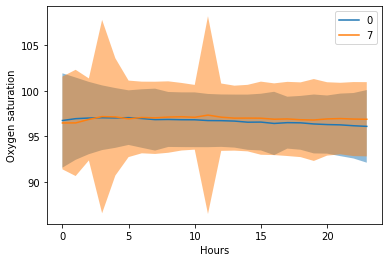

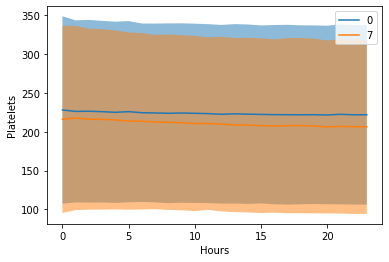

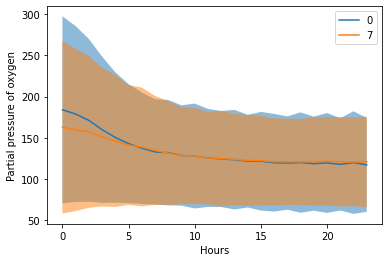

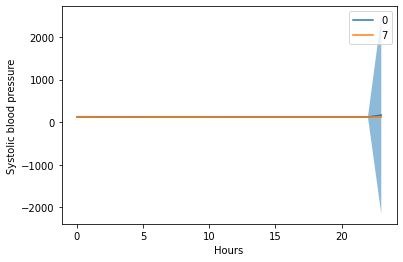

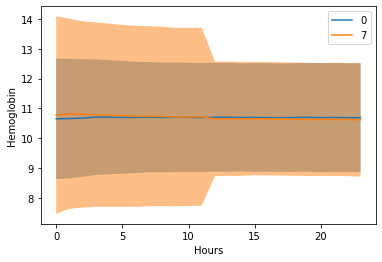

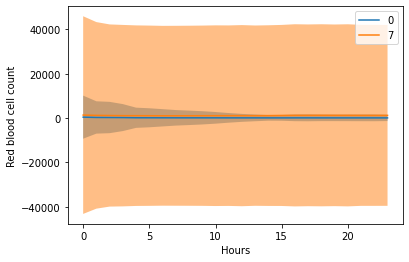

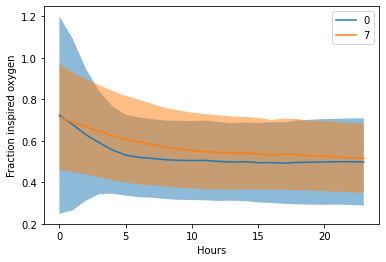

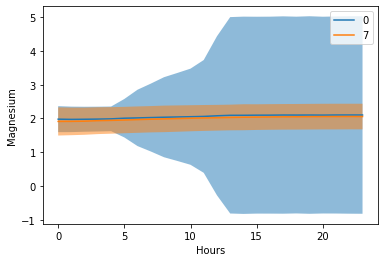

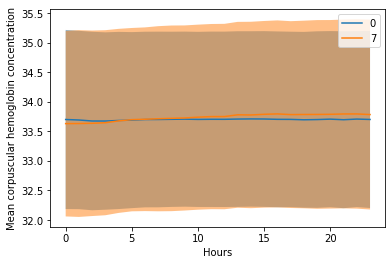

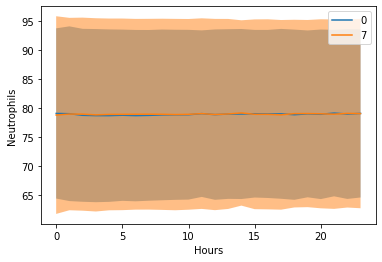

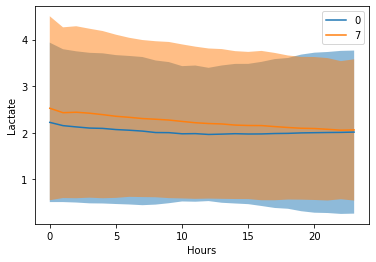

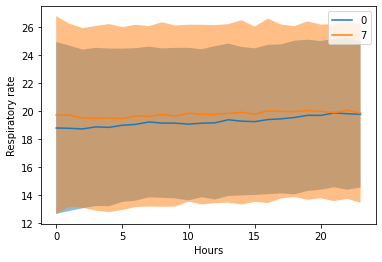

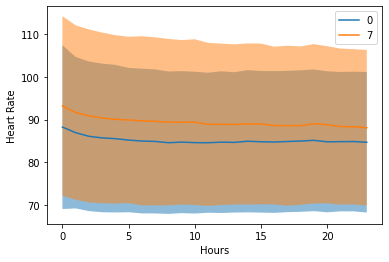

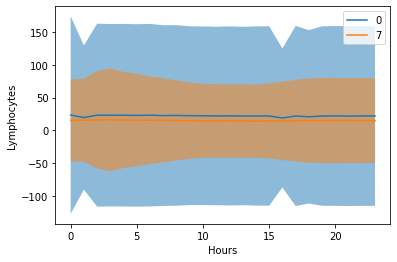

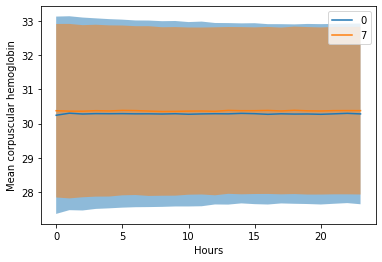

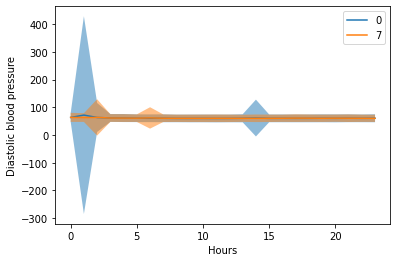

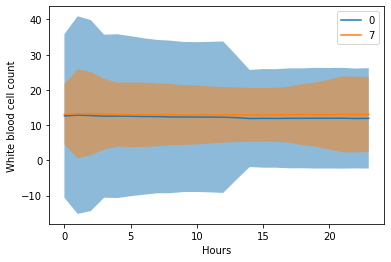

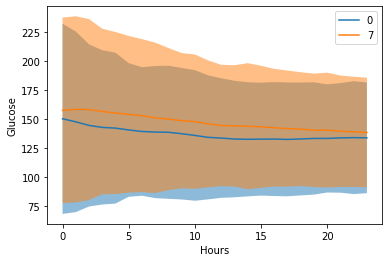

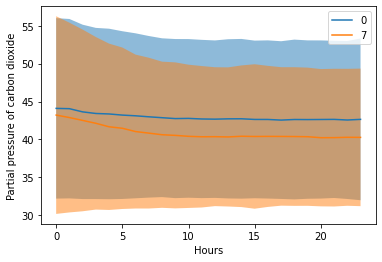

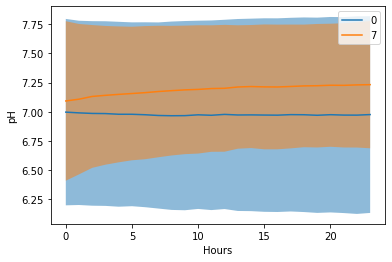

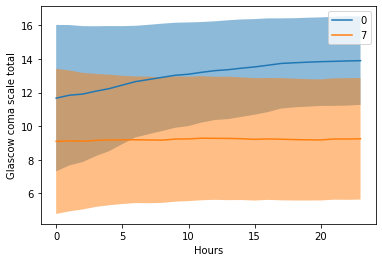

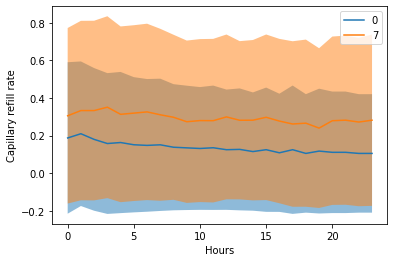

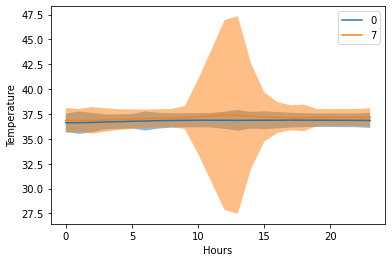

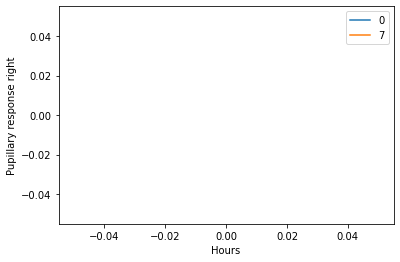

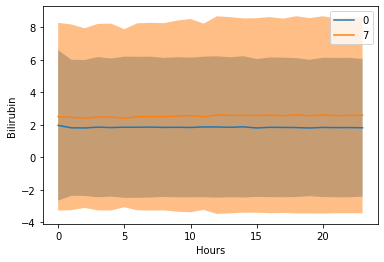

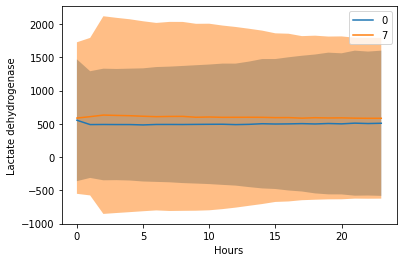

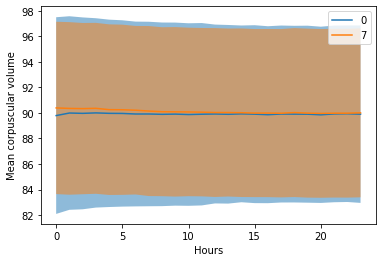

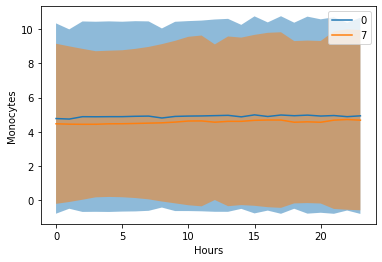

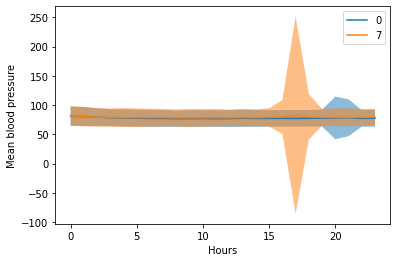

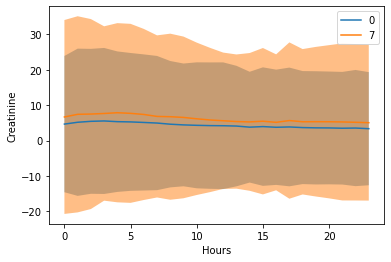

In [147]:
all_fts = set([p.split('_')[0] for p in list(df.columns) ])
for ft in all_fts:
    if ft in ["Hours","label","Height","Weight"]:
        continue
    ax = plot_feature(df,ft,0, hours=24)
    plot_feature(df,ft,7, ax, hours=24)
    ax.legend()

## 48 Hours

In [148]:
df = pd.read_csv('/scratch/koustuvs/mimic/clean_ards_48.csv')

In [149]:
## total patients
len(df)

7349

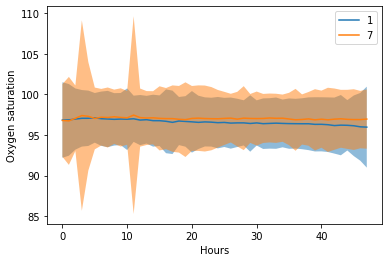

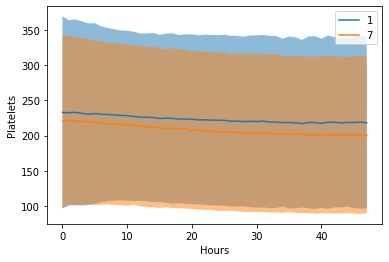

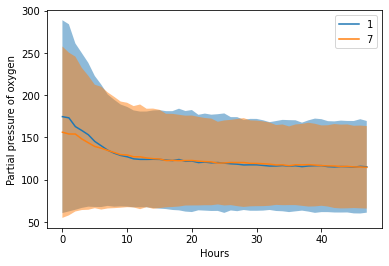

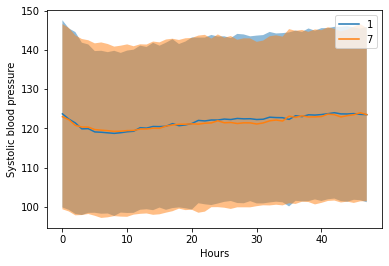

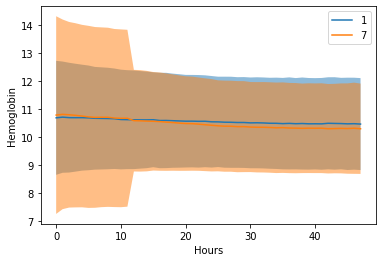

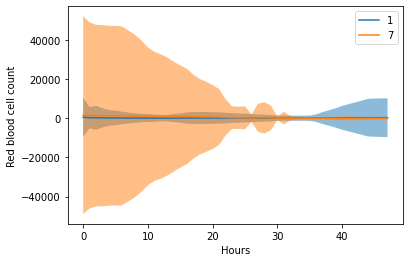

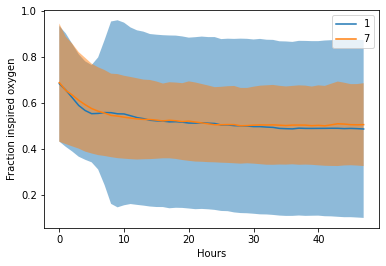

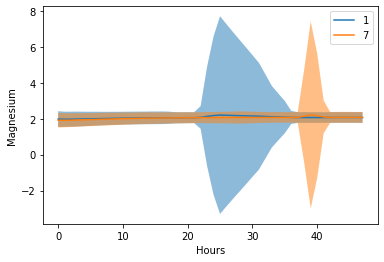

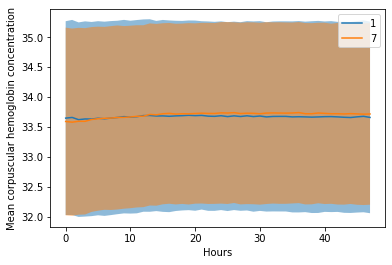

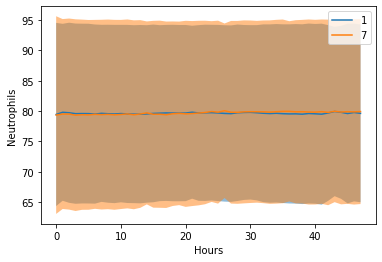

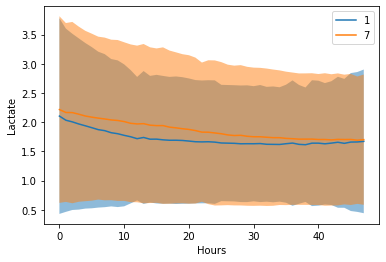

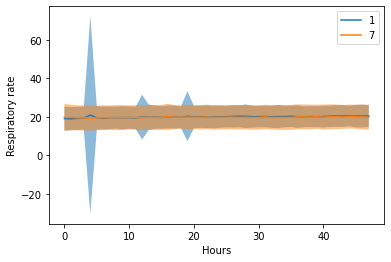

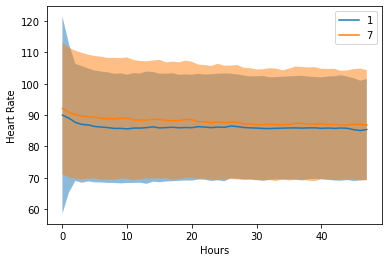

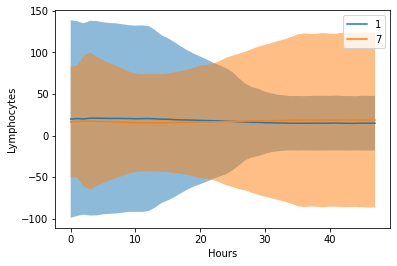

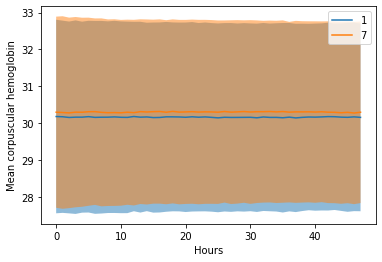

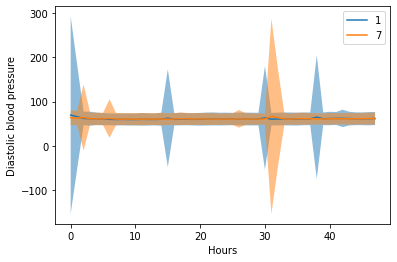

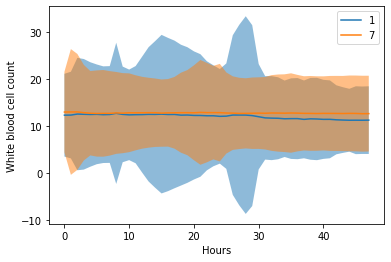

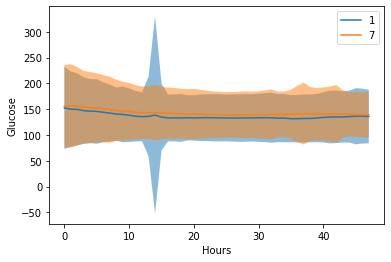

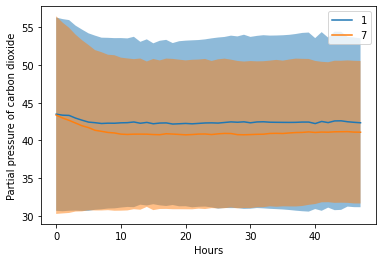

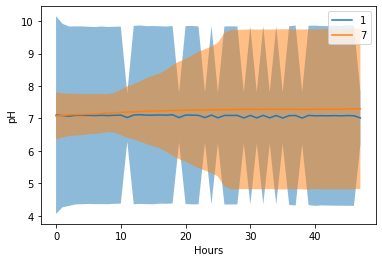

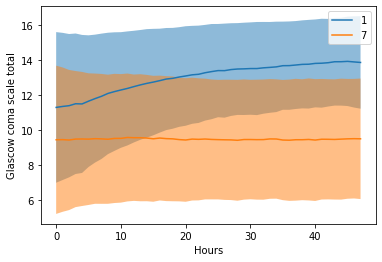

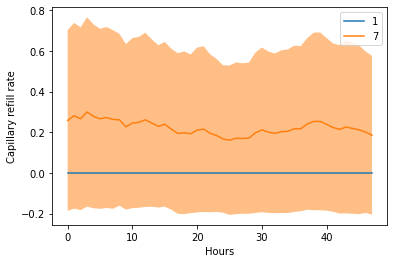

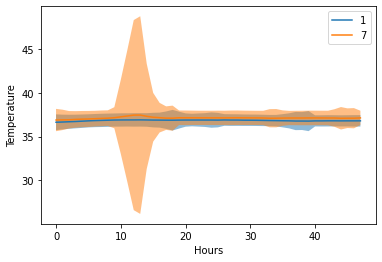

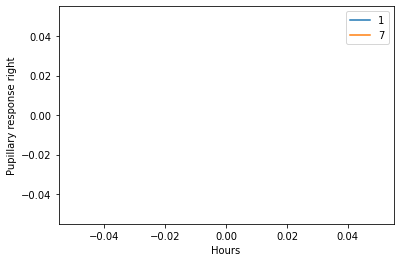

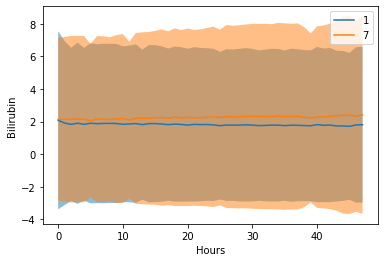

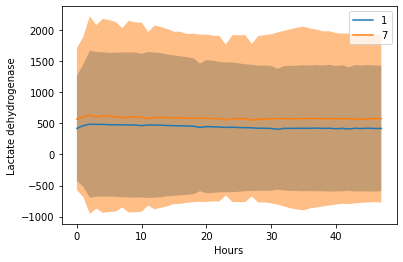

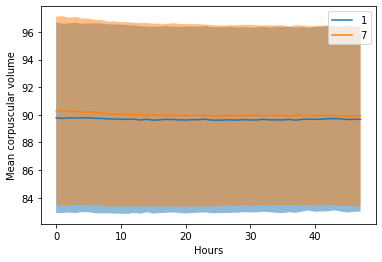

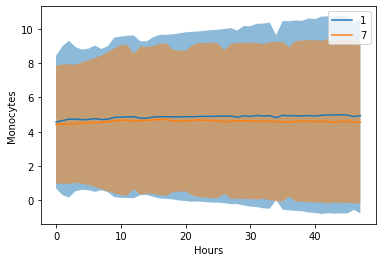

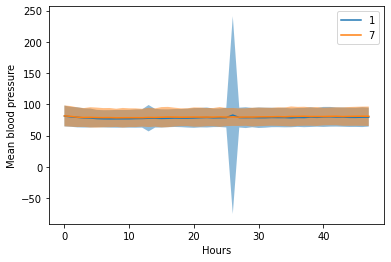

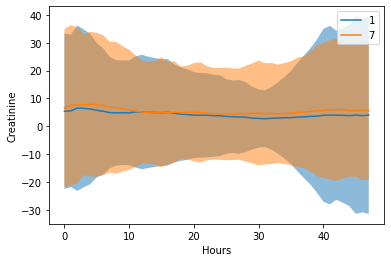

In [150]:
all_fts = set([p.split('_')[0] for p in list(df.columns) ])
for ft in all_fts:
    if ft in ["Hours","label","Height","Weight"]:
        continue
    ax = plot_feature(df,ft,1, hours=48)
    plot_feature(df,ft,7, ax, hours=48)
    ax.legend()